### Regression Project: Estimating Home Value

#### Project Objectives

- Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook Final Report.

- Create modules (acquire.py, prepare.py) that make your process repeateable and your report (notebook) easier to read and follow.

- Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

- Construct a model to predict assessed home value for single family properties using regression techniques.

- Make recommendations to a data science team about how to improve predictions.

- Refine your work into a Report, in the form of a jupyter notebook, that you will walk through in a 5 minute presentation to a group of collegues and managers about the work you did, why, goals, what you found, your methdologies, and your conclusions.

- Be prepared to answer panel questions about your code, process, findings and key takeaways, and model.

In [ ]:
# to do
# REMOVE taxamount FROM MODEL ON SECOND RUN THROUGH!!!! :(
    # drop tax rate too :( :( 
# add column for three fips to table? might be helpful to visualize differences and start
# over or add to round 2 
# put together models
# add more takeaways!
# start readme file
# finally put together deliverable model
# add hypothesis testing for wip v2
# include additional columns from database to see if that helps improve model?

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import env

In [2]:
# Acquisition of data
def zillow_data():
    '''
    This function reads the iris data from the Codeup db into a df.
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips 
                FROM properties_2017
                JOIN propertylandusetype USING(propertylandusetypeid)
                JOIN predictions_2017 USING(parcelid)
                WHERE propertylandusetype.propertylandusetypeid = 261 AND 279
                AND predictions_2017.transactiondate LIKE '2017%%';
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_connection(db, user = env.user, host = env.host, password = env.password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [93]:
df = zillow_data()
df.head(3)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,4.000000,3.500000,3100.000000,1023282.000000,1998.000000,11013.720000,6059.000000
1,2.000000,1.000000,1465.000000,464000.000000,1967.000000,5672.480000,6111.000000
2,3.000000,2.000000,1243.000000,564778.000000,1962.000000,6488.300000,6059.000000


In [69]:
df.shape

(52441, 7)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   taxamount                     52437 non-null  float64
 6   fips                          52441 non-null  float64
dtypes: float64(7)
memory usage: 2.8 MB


In [71]:
df.fips.value_counts()

6037.0    33910
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [72]:
# fips locations obtained from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
fips_table = [[6037.0, 'Los Angeles, CA'],[6059.0, 'Orange, CA'],[6111.0, 'Ventura, CA']]
fips_table = pd.DataFrame(fips_table, columns = ['fips_value', 'location'])
fips_table

,fips_value,location
0,6037.0,"Los Angeles, CA"
1,6059.0,"Orange, CA"
2,6111.0,"Ventura, CA"


In [96]:
def wrangle_zillow(df):
    '''
       This function replaces blank spaces with nan values, then those values are dropped. Finally,              outliers and properties with 0
       bathrooms and less than 200 square feet are dropped.
    '''
    
    # replace blank spaces with nan's
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # drop nan's
    df = df.dropna()
    
    # remove outliers
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis = 1)
    df = df[filtered_entries]
    # removing single family houses with no bathrooms
    df = df[df['bathroomcnt'] != 0]
    # removing single family houses with less than 200 sqared feet
    df = df[df['calculatedfinishedsquarefeet'] > 200]
    # rename columns
    df = df.rename(columns = {'bedroomcnt': 'bedroom_cnt', 'bathroomcnt': 'bathroom_cnt', 'calculatedfinishedsquarefeet': 'square_ft', 'taxvaluedollarcnt': 'assessed_tax_value', 'yearbuilt': 'year_built', 'taxamount': 'tax_amt'})
    # add tax rate column
    df['tax_rate'] = df['tax_amt']/df['assessed_tax_value']
    # map fips codes to locations
    df['location'] = df['fips']
    df['location'] = df['location'].map({6037.0: 'Los Angeles, CA', 6059.0: 'Orange, CA', 6111.0: 'Ventura, CA'})
    # remove homes with unusally high tax rate
    df = train[train['tax_rate'] <= .1]
    
    return df

In [97]:
# clean up df
df = wrangle_zillow(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50693 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedroom_cnt         50693 non-null  float64
 1   bathroom_cnt        50693 non-null  float64
 2   square_ft           50693 non-null  float64
 3   assessed_tax_value  50693 non-null  float64
 4   year_built          50693 non-null  float64
 5   tax_amt             50693 non-null  float64
 6   fips                50693 non-null  float64
 7   tax_rate            50693 non-null  float64
 8   location            50693 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.9+ MB


In [101]:
pd.options.display.float_format = "{:.2f}".format

In [102]:
df.head()

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate,location
0,4.00,3.50,3100.00,1023282.00,1998.00,11013.72,6059.00,0.01,"Orange, CA"
1,2.00,1.00,1465.00,464000.00,1967.00,5672.48,6111.00,0.01,"Ventura, CA"
2,3.00,2.00,1243.00,564778.00,1962.00,6488.30,6059.00,0.01,"Orange, CA"
3,4.00,3.00,2376.00,145143.00,1970.00,1777.51,6037.00,0.01,"Los Angeles, CA"
4,4.00,3.00,2962.00,773303.00,1950.00,9516.26,6037.00,0.01,"Los Angeles, CA"


In [103]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom_cnt,50693.00,3.26,0.88,1.00,3.00,3.00,4.00,6.00
bathroom_cnt,50693.00,2.22,0.86,1.00,2.00,2.00,3.00,5.00
square_ft,50693.00,1826.57,774.39,300.00,1258.00,1634.00,2232.00,4922.00
assessed_tax_value,50693.00,453445.64,386299.31,1000.00,188686.00,364000.00,589019.00,2768405.00
year_built,50693.00,1962.93,22.70,1894.00,1950.00,1960.00,1978.00,2016.00
tax_amt,50693.00,5573.75,4470.97,49.18,2602.06,4534.50,7053.42,32557.42
fips,50693.00,6049.07,21.00,6037.00,6037.00,6037.00,6059.00,6111.00
tax_rate,50693.00,0.01,0.01,0.00,0.01,0.01,0.01,0.82


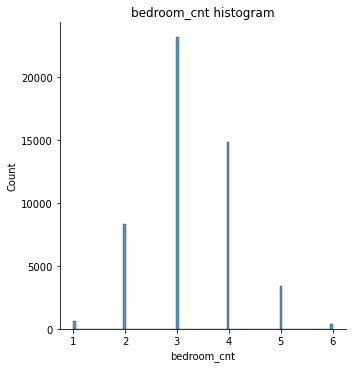

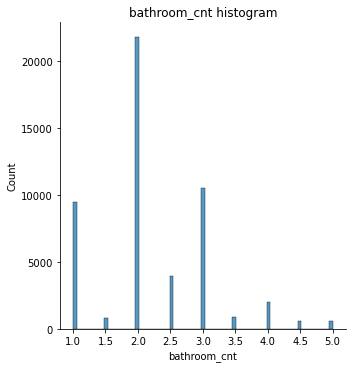

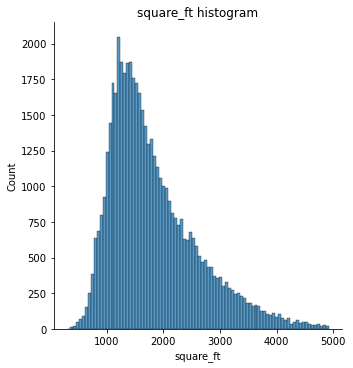

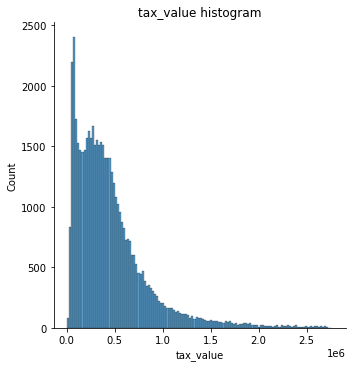

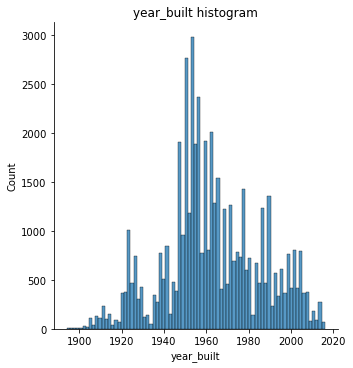

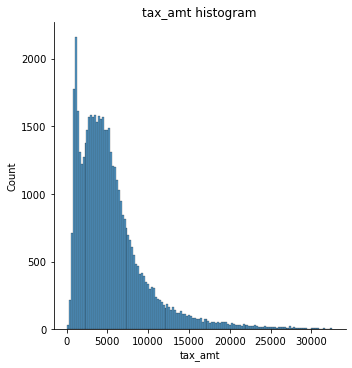

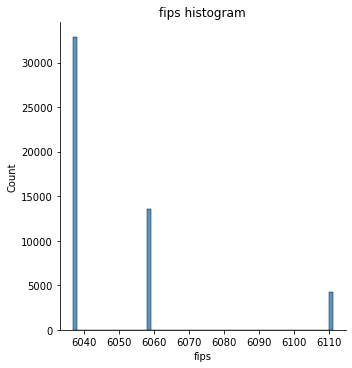

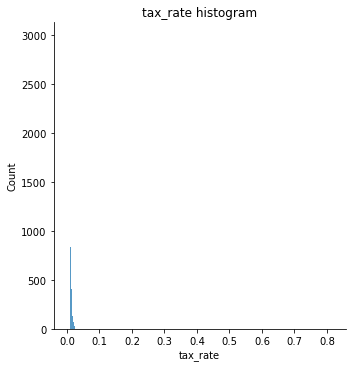

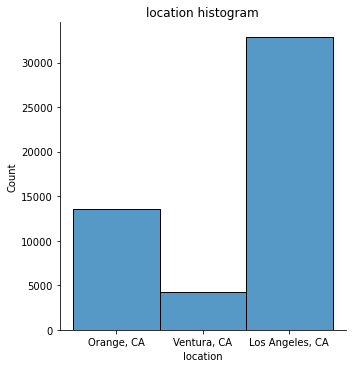

In [76]:
# univariate visualizations
for col in df:
    sns.displot(x = col, data = df)
    plt.title(col + ' histogram')
    plt.show()

In [100]:
num_cols = df.select_dtypes(exclude = 'object')
num_cols

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate
0,4.000000,3.500000,3100.000000,1023282.000000,1998.000000,11013.720000,6059.000000,0.010763
1,2.000000,1.000000,1465.000000,464000.000000,1967.000000,5672.480000,6111.000000,0.012225
2,3.000000,2.000000,1243.000000,564778.000000,1962.000000,6488.300000,6059.000000,0.011488
3,4.000000,3.000000,2376.000000,145143.000000,1970.000000,1777.510000,6037.000000,0.012247
4,4.000000,3.000000,2962.000000,773303.000000,1950.000000,9516.260000,6037.000000,0.012306
...,...,...,...,...,...,...,...,...
52436,4.000000,2.000000,1633.000000,346534.000000,1962.000000,4175.080000,6037.000000,0.012048
52437,2.000000,2.000000,1286.000000,354621.000000,1940.000000,4478.430000,6037.000000,0.012629
52438,4.000000,2.000000,1612.000000,67205.000000,1964.000000,1107.480000,6111.000000,0.016479
52439,3.000000,1.000000,1032.000000,49546.000000,1954.000000,876.430000,6037.000000,0.017689


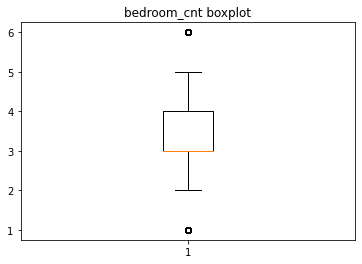

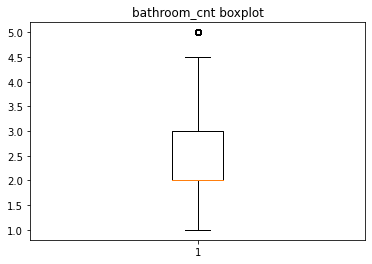

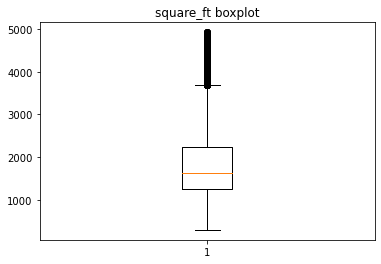

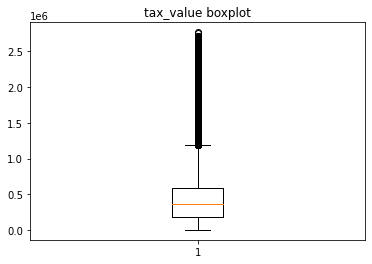

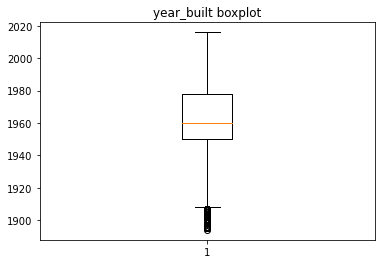

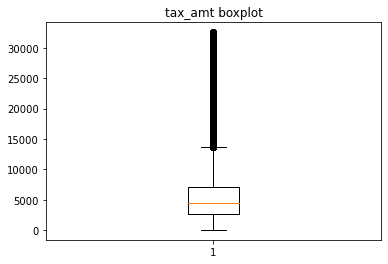

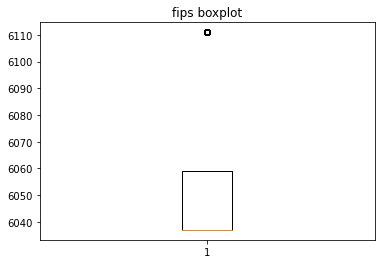

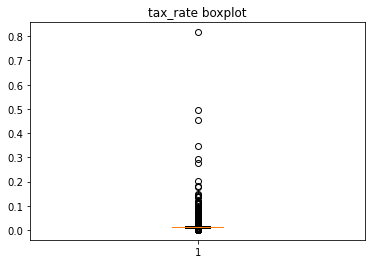

In [78]:
for col in num_cols:
    plt.title(col + ' boxplot')
    plt.boxplot(df[col], meanline = True)
    plt.show();    

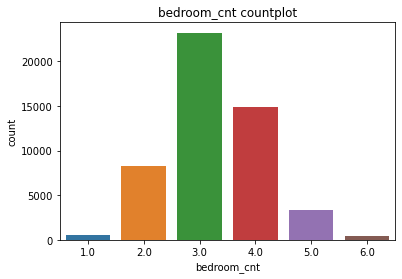

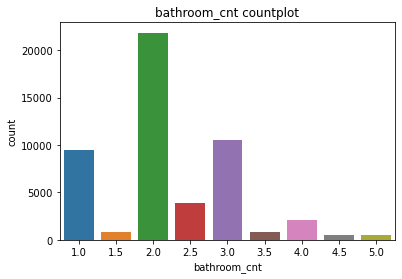

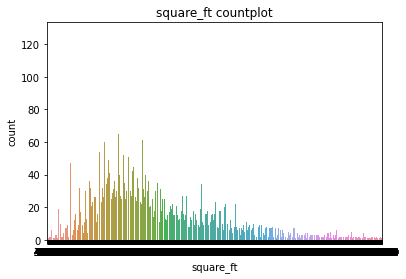

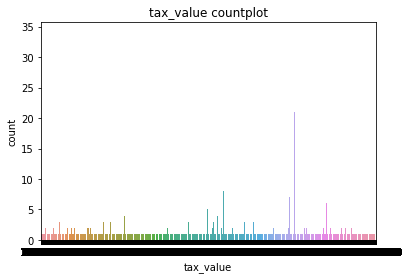

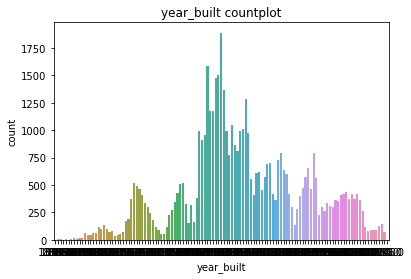

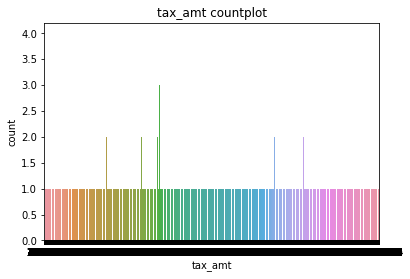

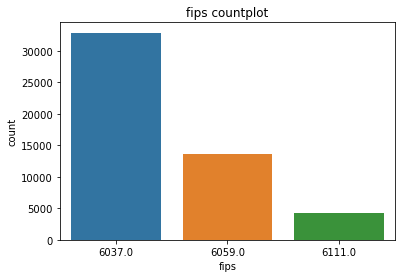

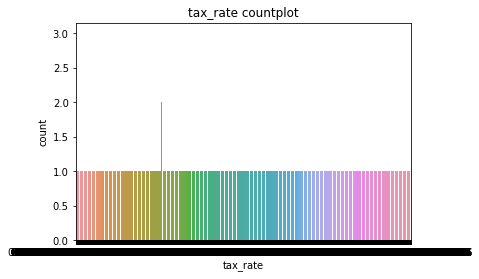

In [47]:
#for col in num_cols:
    sns.countplot(x = col, data = df)
    plt.title(col + ' countplot')
    plt.show()

In [ ]:
# takeaways from univariate visualization
    # most houses have 3 to 4 bedrooms
    # most houses have between 2 and 3 bathrooms
    # curve shape of square_ft, tax_value, and tax_amt are very similar
    # means fall on the lower end of the distributions

In [138]:
encoded_df = pd.get_dummies(df['location'], drop_first = False)
encoded_df

,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
52436,1,0,0
52437,1,0,0
52438,0,0,1
52439,1,0,0


In [145]:
#concat_df = df.drop(columns = ['location', 'yhat_baseline'])
#concat_df = pd.concat([concat_df, encoded_df], axis = 1)
concat_df.head()

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,4.00,3.50,3100.00,1023282.00,1998.00,11013.72,6059.00,0.01,0,1,0
1,2.00,1.00,1465.00,464000.00,1967.00,5672.48,6111.00,0.01,0,0,1
2,3.00,2.00,1243.00,564778.00,1962.00,6488.30,6059.00,0.01,0,1,0
3,4.00,3.00,2376.00,145143.00,1970.00,1777.51,6037.00,0.01,1,0,0
4,4.00,3.00,2962.00,773303.00,1950.00,9516.26,6037.00,0.01,1,0,0


In [147]:
# Exploration
train_and_validate, test = train_test_split(concat_df, random_state = 123)
train, validate = train_test_split(train_and_validate)
test.shape, train.shape, validate.shape

((12674, 11), (28514, 11), (9505, 11))

In [157]:
train_num_cols = df.select_dtypes(exclude = 'object')

In [158]:
train_num_cols

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate
0,4.00,3.50,3100.00,1023282.00,1998.00,11013.72,6059.00,0.01
1,2.00,1.00,1465.00,464000.00,1967.00,5672.48,6111.00,0.01
2,3.00,2.00,1243.00,564778.00,1962.00,6488.30,6059.00,0.01
3,4.00,3.00,2376.00,145143.00,1970.00,1777.51,6037.00,0.01
4,4.00,3.00,2962.00,773303.00,1950.00,9516.26,6037.00,0.01
...,...,...,...,...,...,...,...,...
52436,4.00,2.00,1633.00,346534.00,1962.00,4175.08,6037.00,0.01
52437,2.00,2.00,1286.00,354621.00,1940.00,4478.43,6037.00,0.01
52438,4.00,2.00,1612.00,67205.00,1964.00,1107.48,6111.00,0.02
52439,3.00,1.00,1032.00,49546.00,1954.00,876.43,6037.00,0.02


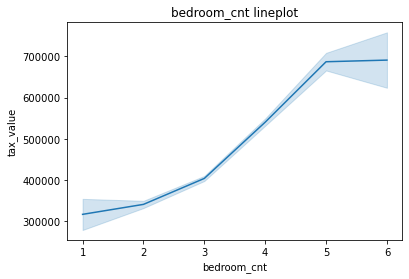

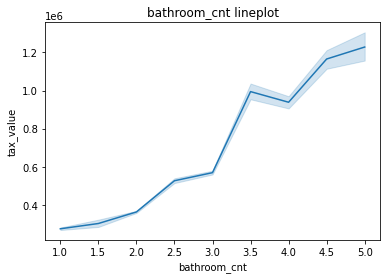

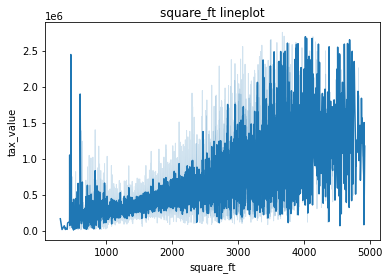

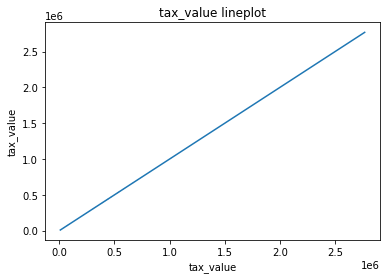

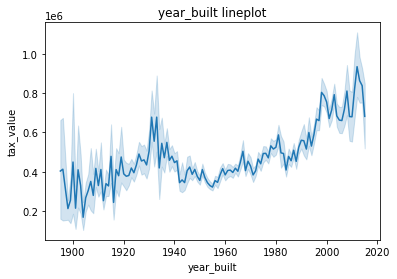

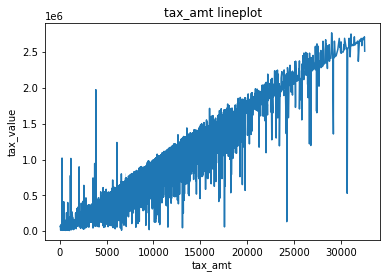

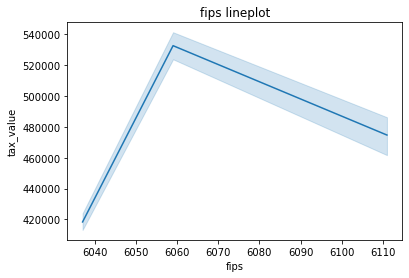

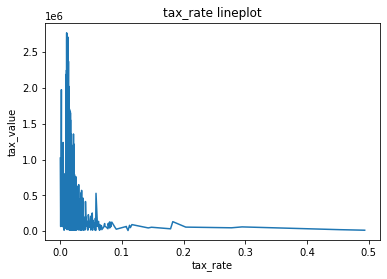

In [52]:
# bivariate visualizations
for col in train_num_cols:
    sns.lineplot(x = col, y = train['assessed_tax_value'], data = train)
    plt.title(col + ' lineplot')
    plt.show()

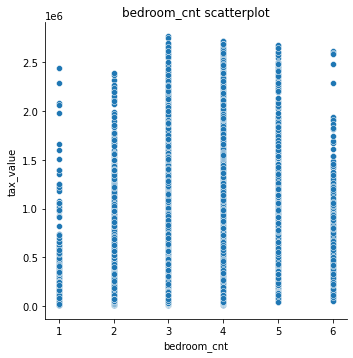

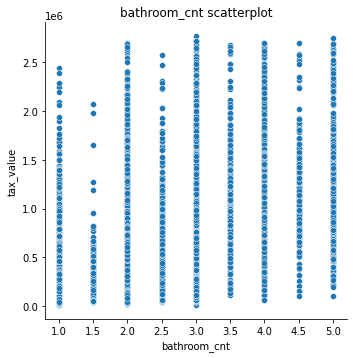

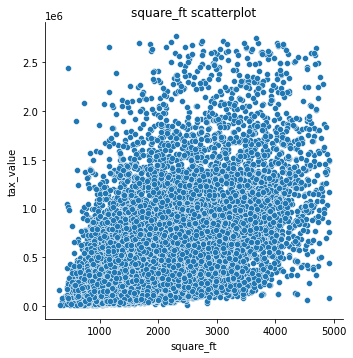

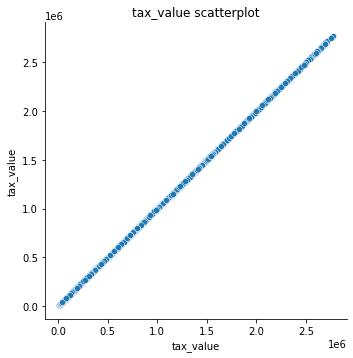

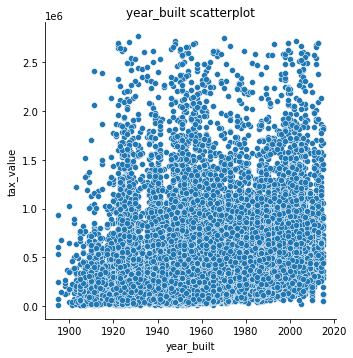

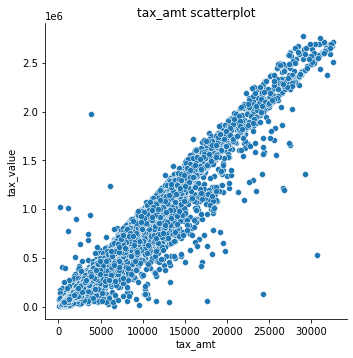

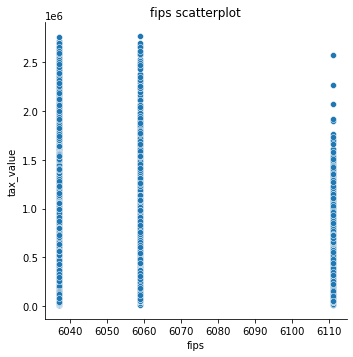

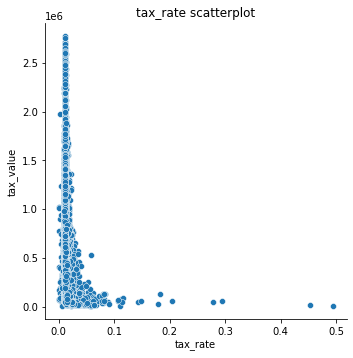

In [56]:
for col in train_num_cols:
    sns.relplot(x = col, y = train['assessed_tax_value'], data = train, kind = 'scatter')
    plt.title(col + ' scatterplot')
    plt.show()

<AxesSubplot:>

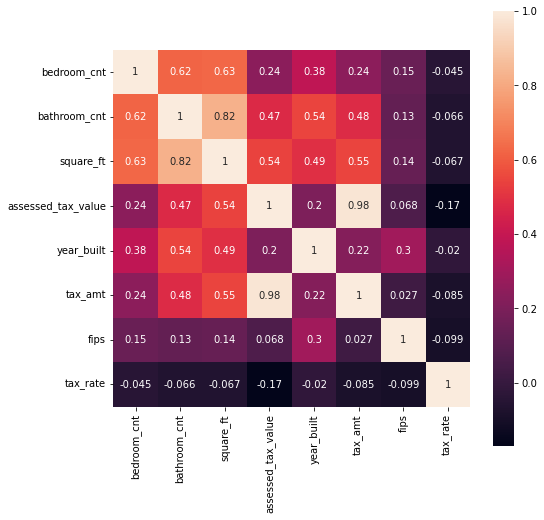

In [117]:
plt.figure(figsize = (8,8))
sns.heatmap(train_num_cols.corr(), square = True, annot = True)

In [ ]:
# takeaways
    # the lineplot helps me see that most independent variables chosen do correlate with
    # higher tax value with the exception of fips and tax_rate.
    # tax amount and tax value correlate pretty closely
    # the more rooms (bed and bath) the higher the tax value
    # newer houses have higher tax value as well
    # the scatter plots don't really tell me much, or i'm not able to make out much from it
    # the heatmap goes hand in hand with the lineplot in that a handful of the features have
    # higher than .4 correlation with the target tax_value, these values being tax_amt, 
    # square_ft, and bathroom_cnt

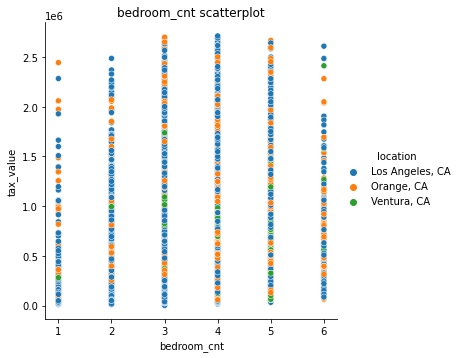

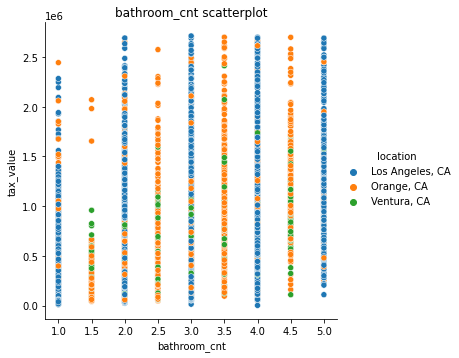

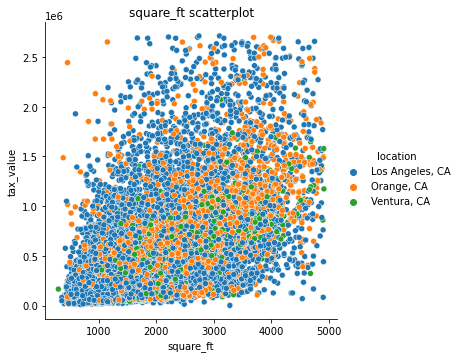

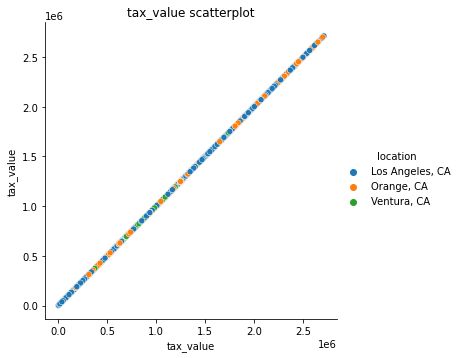

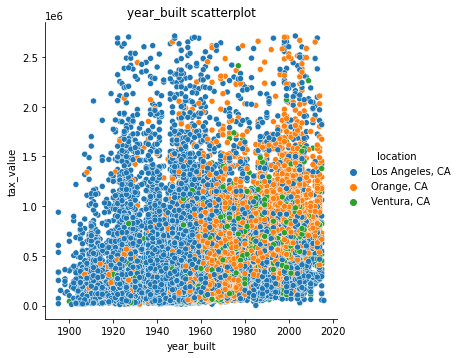

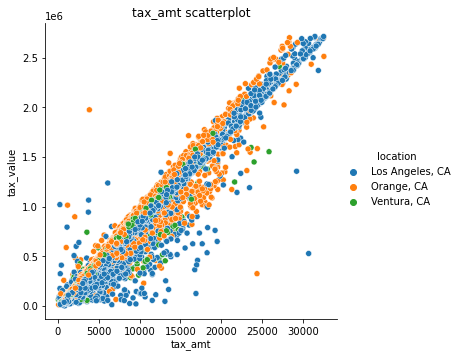

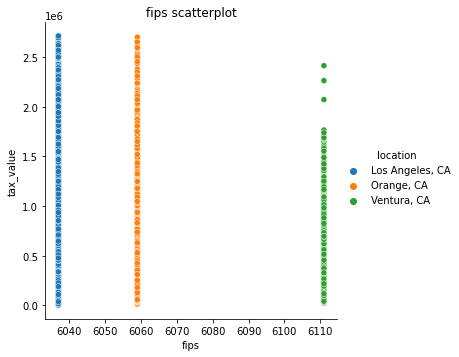

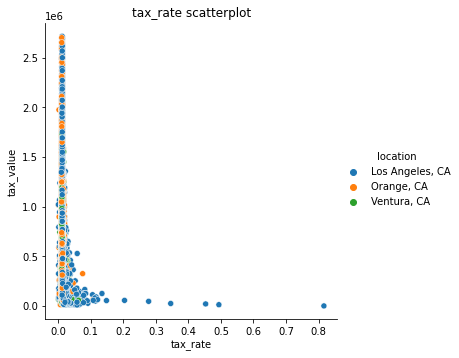

In [91]:
# multivariate visualizations

for col in train_num_cols:
    sns.relplot(x = col, y = train['assessed_tax_value'], data = train, kind = 'scatter', hue = 'location')
    plt.title(col + ' scatterplot')
    plt.show()

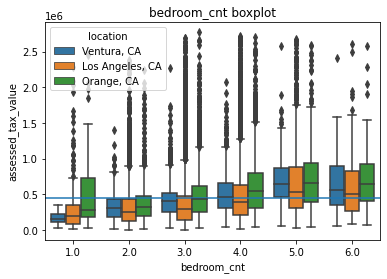

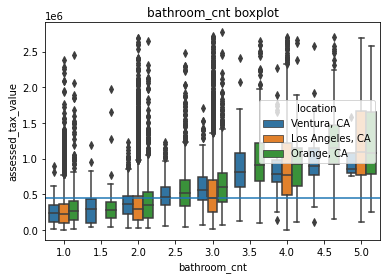

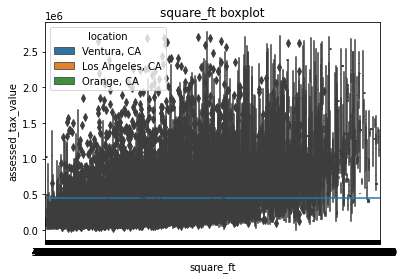

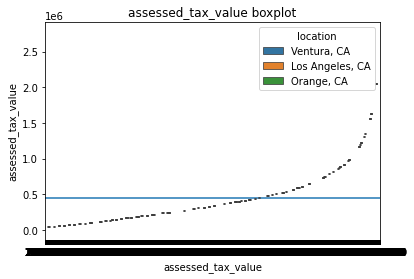

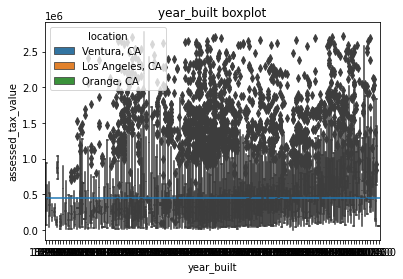

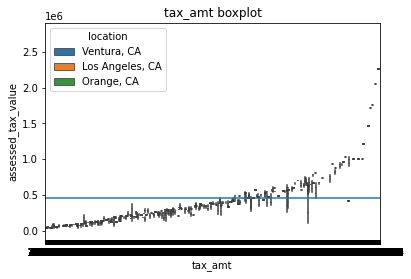

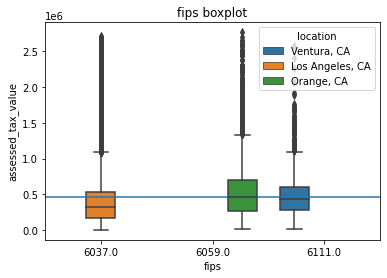

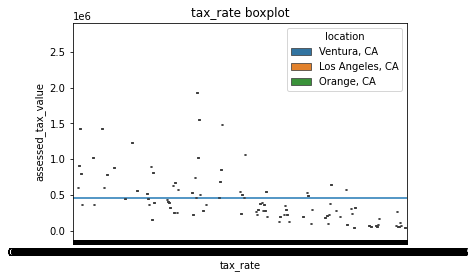

In [109]:
#for col in num_cols:
    plt.title(col + ' boxplot')
    sns.boxplot(x = col, y = 'assessed_tax_value', data = train, hue = 'location')
    mean_assessed_tax = train.assessed_tax_value.mean()
    plt.axhline(mean_assessed_tax)
    plt.show()

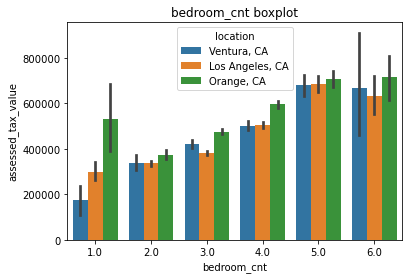

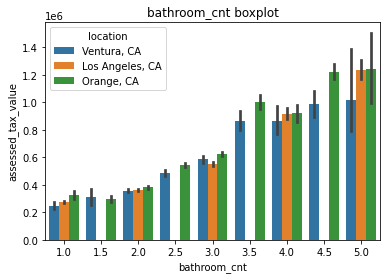

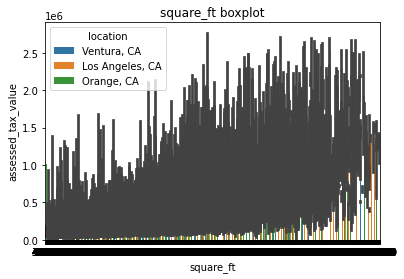

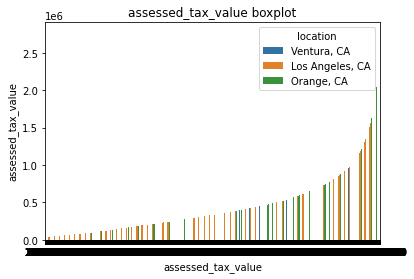

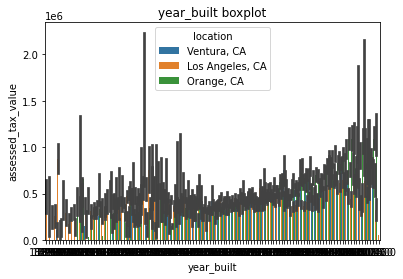

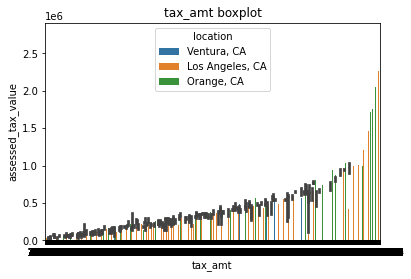

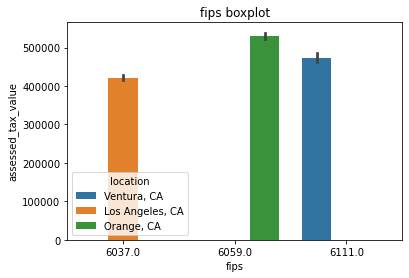

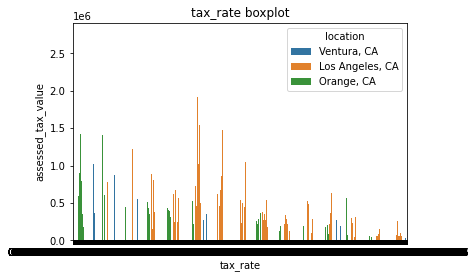

In [110]:
for col in num_cols:
    plt.title(col + ' boxplot')
    sns.barplot(x = col, y = 'assessed_tax_value', data = train, hue = 'location')
    mean_assessed_tax = train.assessed_tax_value.mean()
    plt.show()

<AxesSubplot:xlabel='location', ylabel='assessed_tax_value'>

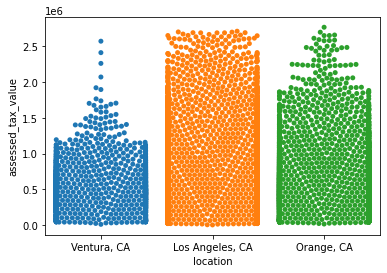

In [112]:
sns.swarmplot(x = 'location', y = 'assessed_tax_value', data = train)

<AxesSubplot:xlabel='location', ylabel='assessed_tax_value'>

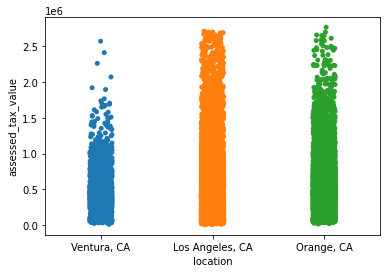

In [113]:
sns.stripplot(x = 'location', y = 'assessed_tax_value', data = train)

<AxesSubplot:xlabel='location', ylabel='assessed_tax_value'>

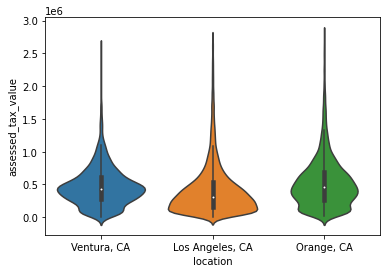

In [114]:
sns.violinplot(x = 'location', y = 'assessed_tax_value', data = train)

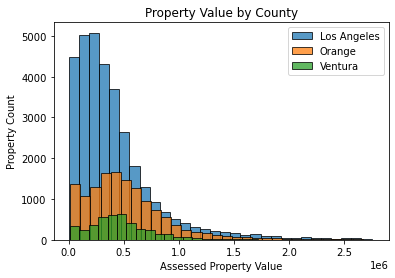

In [243]:
plt.title('Property Value by County')
df.assessed_tax_value[df.location == 'Los Angeles, CA'].hist(edgecolor = 'black', bins = 30, label = 'Los Angeles', alpha=.75)
df.assessed_tax_value[df.location == 'Orange, CA'].hist(edgecolor = 'black', bins = 30, label = 'Orange', alpha=.75)
df.assessed_tax_value[df.location == 'Ventura, CA'].hist(edgecolor = 'black', bins = 30, label = 'Ventura', alpha=.75)
plt.grid(False)
plt.xlabel('Assessed Property Value')
plt.ylabel('Property Count')
plt.legend();

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50693 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedroom_cnt         50693 non-null  float64
 1   bathroom_cnt        50693 non-null  float64
 2   square_ft           50693 non-null  float64
 3   assessed_tax_value  50693 non-null  float64
 4   year_built          50693 non-null  float64
 5   tax_amt             50693 non-null  float64
 6   fips                50693 non-null  float64
 7   tax_rate            50693 non-null  float64
 8   location            50693 non-null  object 
 9   pred_mean           50693 non-null  float64
 10  pred_median         50693 non-null  float64
dtypes: float64(10), object(1)
memory usage: 4.6+ MB


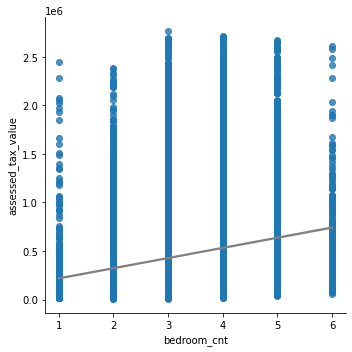

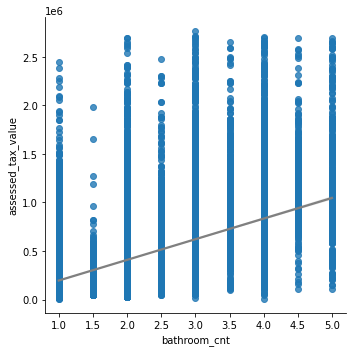

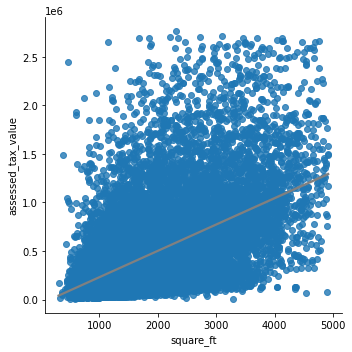

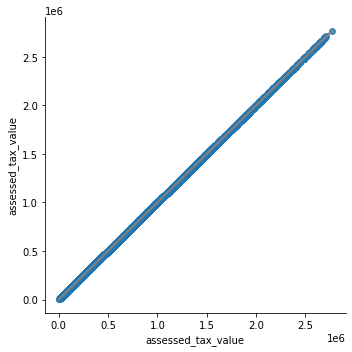

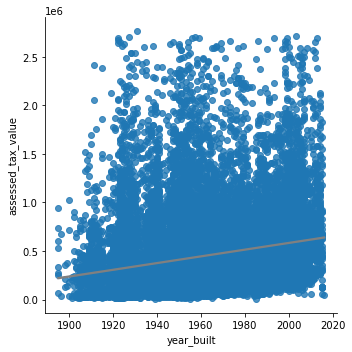

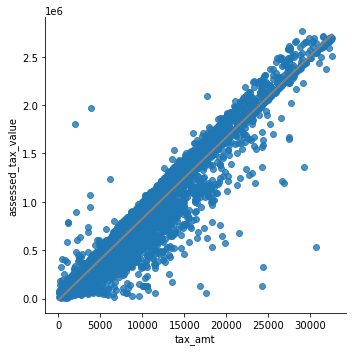

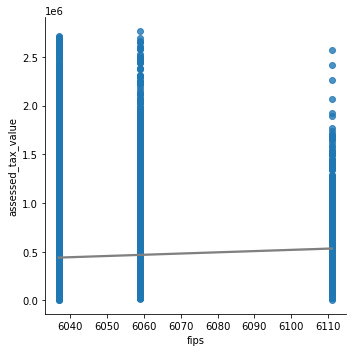

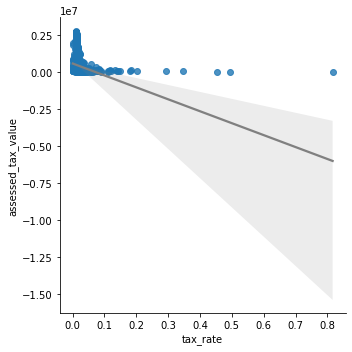

In [121]:
for col in num_cols:
    sns.lmplot(x = col, y = 'assessed_tax_value', data = train, line_kws = {'color': 'gray'})
    plt.show()

In [118]:
train.location.value_counts()

Los Angeles, CA    18489
Orange, CA          7643
Ventura, CA         2382
Name: location, dtype: int64

In [135]:
train[train['tax_rate'] > .1]

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate,location
5844,2.00,1.00,820.00,25417.00,1946.00,8782.92,6037.00,0.35,"Los Angeles, CA"
29071,3.00,2.00,1754.00,56697.00,1947.00,11541.02,6037.00,0.20,"Los Angeles, CA"
42000,3.00,4.00,3284.00,1000.00,1985.00,816.49,6037.00,0.82,"Los Angeles, CA"
49767,2.00,1.00,500.00,9242.00,1939.00,1016.38,6111.00,0.11,"Ventura, CA"
14857,3.00,2.00,1386.00,57524.00,1951.00,8084.79,6037.00,0.14,"Los Angeles, CA"
18042,2.00,1.00,860.00,91724.00,1947.00,10666.54,6037.00,0.12,"Los Angeles, CA"
3521,3.00,1.00,1540.00,64181.00,1951.00,7742.59,6037.00,0.12,"Los Angeles, CA"
49585,3.00,3.00,2490.00,13352.00,1965.00,6591.18,6037.00,0.49,"Los Angeles, CA"
22290,3.00,1.00,1504.00,59629.00,1950.00,17582.50,6111.00,0.29,"Ventura, CA"
30939,2.00,1.00,572.00,21074.00,1924.00,9544.07,6037.00,0.45,"Los Angeles, CA"


In [ ]:
# takeaways
    # LA doesn't seem to have half bathrooms
    # Ventura falls in the mid range of assessed taxes in comparison to orange and LA
    # more locations in LA, than Orange and finally Ventura
    # the majority of the houses with 4+ rooms are in LA and Orange
    # most newest houses are in Orange
    # majority of houses are in LA
    # not multivariate exploration but just noticed that there are some homes with a higher
    # than normal tax rate. There doesn't seem to be a reason I can see why this is happening,
    # might need to go back on round two and remove these additional rows at tax rate
    # higher than 10% 

In [178]:
# modeling
# baseline
baseline = df
baseline['pred_mean'] = baseline.assessed_tax_value.mean()
baseline['pred_median'] = baseline.assessed_tax_value.median()
baseline.head()

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate,location,pred_mean,pred_median
0,4.00,3.50,3100.00,1023282.00,1998.00,11013.72,6059.00,0.01,"Orange, CA",453445.64,364000.00
1,2.00,1.00,1465.00,464000.00,1967.00,5672.48,6111.00,0.01,"Ventura, CA",453445.64,364000.00
2,3.00,2.00,1243.00,564778.00,1962.00,6488.30,6059.00,0.01,"Orange, CA",453445.64,364000.00
3,4.00,3.00,2376.00,145143.00,1970.00,1777.51,6037.00,0.01,"Los Angeles, CA",453445.64,364000.00
4,4.00,3.00,2962.00,773303.00,1950.00,9516.26,6037.00,0.01,"Los Angeles, CA",453445.64,364000.00


In [179]:
b_train_and_validate, b_test = train_test_split(baseline, random_state = 123)
b_train, b_validate = train_test_split(b_train_and_validate)

In [182]:
target = "assessed_tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
b_X_train = b_train.drop(columns = [target])
b_y_train = b_train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
b_X_validate = b_validate.drop(columns = [target])
b_y_validate = b_validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
b_X_test = b_test.drop(columns = [target])
b_y_test = b_test[target]

b_y_train

49712    763096.00
38852    155784.00
11792   1056917.00
20180    185513.00
1782     969563.00
           ...    
34144    435127.00
13526    422081.00
12625    122729.00
1034     123785.00
26724    636437.00
Name: assessed_tax_value, Length: 28514, dtype: float64

In [186]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
b_y_train = pd.DataFrame(b_y_train)
b_y_validate = pd.DataFrame(b_y_validate)

# 1. Predict G3_pred_mean
b_pred_mean = b_y_train['assessed_tax_value'].mean()
b_y_train['pred_mean'] = b_pred_mean
b_y_validate['pred_mean'] = b_pred_mean

# 2. compute G3_pred_median
b_pred_median = b_y_train['assessed_tax_value'].median()
b_y_train['pred_median'] = b_pred_median
b_y_validate['pred_median'] = b_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_median)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  386918.18 
Validate/Out-of-Sample:  387094.82
RMSE using Median
Train/In-Sample:  397222.74 
Validate/Out-of-Sample:  397772.46


In [160]:
# feature selection

target = 'assessed_tax_value'

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns = [target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns = [target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns = [target])
y_test = test[target]

X_train.head()

,bedroom_cnt,bathroom_cnt,square_ft,year_built,tax_amt,fips,tax_rate,"Los Angeles, CA","Orange, CA","Ventura, CA"
7868,4.00,2.00,1522.00,1965.00,6293.94,6059.00,0.01,0,1,0
31023,3.00,2.00,1467.00,1947.00,6477.03,6037.00,0.01,1,0,0
47851,5.00,4.50,3725.00,1999.00,9387.86,6111.00,0.01,0,0,1
39147,4.00,2.00,1200.00,1954.00,4400.60,6037.00,0.01,1,0,0
27350,2.00,2.00,1533.00,1954.00,4300.70,6059.00,0.01,0,1,0


In [161]:
def standard_scaler_tvt(train, validate, test):
    # list of columns float and int dtypes
    num_cols = list(train.select_dtypes(include = ['float64', 'int64', 'complex']).columns)
    
    # standard scaler object
    scaler = sklearn.preprocessing.StandardScaler()
    
    # fit scaler
    scaler.fit(train[num_cols])
    
    # scale
    train_scaled = scaler.transform(train[num_cols])
    validate_scaled = scaler.transform(validate[num_cols])
    test_scaled = scaler.transform(test[num_cols])

    # new column names
    #new_column_names = [c + '_scaled' for c in num_cols]

    # add scaled columns to input dataset
    #train[new_column_names] = scaler.transform(train[num_cols])
    #validate[new_column_names] = scaler.transform(train[num_cols])
    #test[new_column_names] = scaler.transform(train[num_cols])
    
    # add column names if scaled df is needed separately
    train_scaled = pd.DataFrame(train_scaled, columns = num_cols)
    validate_scaled = pd.DataFrame(validate_scaled, columns = num_cols)
    test_scaled = pd.DataFrame(test_scaled, columns = num_cols)
    
    return train_scaled, validate_scaled, test_scaled

In [162]:
train_scaled, validate_scaled, test_scaled = standard_scaler_tvt(train, validate, test)

In [167]:
train_scaled

,bedroom_cnt,bathroom_cnt,square_ft,assessed_tax_value,year_built,tax_amt,fips,tax_rate
0,0.84,-0.26,-0.40,0.17,0.09,0.15,0.47,-0.17
1,-0.30,-0.26,-0.47,0.17,-0.70,0.19,-0.58,-0.13
2,1.97,2.66,2.44,0.99,1.58,0.84,2.94,-0.28
3,0.84,-0.26,-0.81,-0.23,-0.39,-0.27,-0.58,-0.17
4,-1.43,-0.26,-0.38,-0.29,-0.39,-0.29,0.47,-0.12
...,...,...,...,...,...,...,...,...
28509,1.97,2.66,2.72,3.13,2.07,3.94,0.47,0.06
28510,0.84,0.33,0.54,0.83,0.35,0.63,2.94,-0.32
28511,-1.43,-1.42,-0.81,-0.57,-0.57,-0.52,-0.58,0.05
28512,0.84,0.91,1.97,0.56,1.76,0.86,-0.58,0.08


In [250]:
target = "assessed_tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train_scaled = train_scaled.drop(columns = [target])
y_train_scaled = train_scaled[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate_scaled = validate_scaled.drop(columns = [target])
y_validate_scaled = validate_scaled[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test_scaled = test_scaled.drop(columns = [target])
y_test_scaled = test_scaled[target]

X_train_scaled.head()

,bedroom_cnt,bathroom_cnt,square_ft,year_built,tax_amt,fips,tax_rate
0,0.84,-0.26,-0.40,0.09,0.15,0.47,-0.17
1,-0.30,-0.26,-0.47,-0.70,0.19,-0.58,-0.13
2,1.97,2.66,2.44,1.58,0.84,2.94,-0.28
3,0.84,-0.26,-0.81,-0.39,-0.27,-0.58,-0.17
4,-1.43,-0.26,-0.38,-0.39,-0.29,0.47,-0.12


In [174]:
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 3)

rfe.fit(X_train_scaled, y_train_scaled)

rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
print('The best six features are: ', rfe_columns)

The best six features are:  ['tax_amt', 'fips', 'tax_rate']


In [169]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by = "Rank", ascending = True)
    return ranks

In [175]:
show_features_rankings(X_train_scaled, rfe)

,Var,Rank
4,tax_amt,1
5,fips,1
6,tax_rate,1
3,year_built,2
2,square_ft,3
0,bedroom_cnt,4
1,bathroom_cnt,5


In [ ]:
# takeaways
    # on second round, tax_rate and tax_amt will be removed
    # bathroom count is ranked fifth, for this first round of modeling, I'll drop it from
    # the train, test, validate datasets

In [217]:
X_train_scaled = X_train_scaled.drop(columns = ['bathroom_cnt'])

X_validate_scaled = X_validate_scaled.drop(columns = ['bathroom_cnt'])

X_test_scaled = X_test_scaled.drop(columns = ['bathroom_cnt'])

In [221]:
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_train_scaled

,assessed_tax_value
0,0.17
1,0.17
2,0.99
3,-0.23
4,-0.29
...,...
28509,3.13
28510,0.83
28511,-0.57
28512,0.56


In [222]:
# OLS
ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_ols)**(1/2)

# predict validate
y_validate_scaled['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.18196697165385398 
Validation/Out-of-Sample:  0.17851181395830157


In [244]:
# OLS
ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  70699.49826615994 
Validation/Out-of-Sample:  69357.06830051378


In [245]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_lasso'] = lasso.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate_scaled)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  70701.59317268779 
Validation/Out-of-Sample:  69391.47440977934


In [246]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  180819.13539653423 
Validation/Out-of-Sample:  176198.56012694363


In [247]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [248]:
lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.assessed_tax_value)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  52139.418032983136 
Validation/Out-of-Sample:  54514.91590744515


In [251]:
X_train_scaled

,bedroom_cnt,bathroom_cnt,square_ft,year_built,tax_amt,fips,tax_rate
0,0.84,-0.26,-0.40,0.09,0.15,0.47,-0.17
1,-0.30,-0.26,-0.47,-0.70,0.19,-0.58,-0.13
2,1.97,2.66,2.44,1.58,0.84,2.94,-0.28
3,0.84,-0.26,-0.81,-0.39,-0.27,-0.58,-0.17
4,-1.43,-0.26,-0.38,-0.39,-0.29,0.47,-0.12
...,...,...,...,...,...,...,...
28509,1.97,2.66,2.72,2.07,3.94,0.47,0.06
28510,0.84,0.33,0.54,0.35,0.63,2.94,-0.32
28511,-1.43,-1.42,-0.81,-0.57,-0.52,-0.58,0.05
28512,0.84,0.91,1.97,1.76,0.86,-0.58,0.08


In [256]:
X_train_scaled = X_train_scaled.drop(columns = ['year_built', 'tax_amt', 'fips', 'tax_rate'])
X_validate_scaled = X_validate_scaled.drop(columns = ['year_built', 'tax_amt', 'fips', 'tax_rate'])
X_test_scaled = X_test_scaled.drop(columns = ['year_built', 'tax_amt', 'fips', 'tax_rate'])

In [257]:
X_train_scaled

,bedroom_cnt,bathroom_cnt,square_ft
0,0.84,-0.26,-0.40
1,-0.30,-0.26,-0.47
2,1.97,2.66,2.44
3,0.84,-0.26,-0.81
4,-1.43,-0.26,-0.38
...,...,...,...
28509,1.97,2.66,2.72
28510,0.84,0.33,0.54
28511,-1.43,-1.42,-0.81
28512,0.84,0.91,1.97


In [258]:
# OLS
ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  320491.38023318985 
Validation/Out-of-Sample:  314360.6626735872


In [259]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_lasso'] = lasso.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate_scaled)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  320491.64824365324 
Validation/Out-of-Sample:  314358.9717933949


In [260]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  321144.2535641153 
Validation/Out-of-Sample:  313637.1106413175


In [261]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [262]:
lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.assessed_tax_value)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  318320.29715130787 
Validation/Out-of-Sample:  311440.0248272983
